Dataset link : https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Model, Sequential 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanSquaredLogarithmicError

import warnings 
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv('creditcard.csv') 
data.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape 

(284807, 31)

In [5]:
data.isnull().sum().sum() 

0

In [6]:
data['Class'].value_counts() 

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
# Target = data['Class'] ==> Last Column
# 0 = Normal, 1 = Anomaly 

X = data.drop(columns=['Class'],axis=1) 
y = data['Class'] 

print(X.shape)  
print(y.shape) 

(284807, 30)
(284807,)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) 

Since, this is a case of novelty detection, we use only normal data for training

In [9]:
train_index = y_train[y_train == 0].index 
train_data = x_train.loc[train_index] 

#### Scale data using MinMax Scaler

In [10]:
min_max_scaler = MinMaxScaler(feature_range=(0,1)) 
# x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
# x_test_scaled = min_max_scaler.transform(x_test.copy()) 

x_train_scaled = x_train 
x_test_scaled = x_test 

#### Build an Autoencoder Model 

Creating an Autoencoder model using Tensorflow

In [11]:
class Autoencoder(Model):
    def __init__(self, output_units, code_size=8):
        super().__init__() 
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self,inputs):
        encoded = self.encoder(inputs) 
        decoded = self.decoder(encoded) 
        return decoded     

In [12]:
model = Autoencoder(output_units=x_train_scaled.shape[1]) 
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(x_train_scaled,x_train_scaled,
                    epochs=20,batch_size=512,
                    validation_data=(x_test_scaled,x_test_scaled))



Epoch 1/20


446/446 [==============================] - 3s 4ms/step - loss: 4.1932 - mse: 375273440.0000 - val_loss: 4.1725 - val_mse: 373017216.0000
Epoch 2/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1758 - mse: 375273248.0000 - val_loss: 4.1720 - val_mse: 373017216.0000
Epoch 3/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1754 - mse: 375273216.0000 - val_loss: 4.1720 - val_mse: 373017216.0000
Epoch 4/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1751 - mse: 375273504.0000 - val_loss: 4.1720 - val_mse: 373017216.0000
Epoch 5/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1751 - mse: 375273568.0000 - val_loss: 4.1720 - val_mse: 373017216.0000
Epoch 6/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1751 - mse: 375273248.0000 - val_loss: 4.1720 - val_mse: 373017216.0000
Epoch 7/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1751 - mse: 375273312.0000 - val

### Plot History

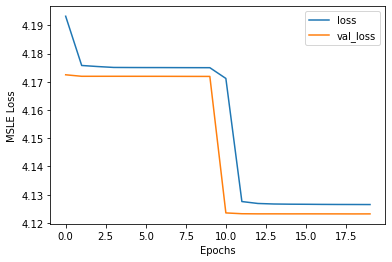

In [13]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.xlabel('Epochs') 
plt.ylabel('MSLE Loss') 
plt.legend(['loss','val_loss']) 
plt.show() 

#### Find Threshold

In [14]:
def find_threshold_method_1(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled)
    reconstruction_errors = tf.keras.losses.msle(reconstructions,x_train_scaled)

    threshold = np.mean(reconstruction_errors.numpy())+np.std(reconstruction_errors.numpy())
    return threshold 

def find_threshold_method_2(model, x_train_scaled):
    reconstructions = model.predict(x_train_scaled) 
    reconstruction_error = tf.keras.losses.msle(reconstructions, x_train_scaled)
    threshold2 = np.percentile(reconstruction_error,95)
    return threshold2 

def get_predictions(model, x_test_scaled, threshold):
    predictions = model.predict(x_test_scaled) 
    errors = tf.keras.losses.msle(predictions,x_test_scaled) 
    normal_mask = pd.Series(errors)>threshold 
    preds = normal_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds 

In [15]:
threshold = find_threshold_method_1(model,x_train_scaled)
print(f"Threshold from method 1 : {threshold}") 

threshold2 = find_threshold_method_2(model,x_train_scaled)
print(f"Threshold from method 2 : {threshold2}") 

7121/7121 [==============================] - 6s 809us/step
Threshold from method 1 : 4.731797234789657
7121/7121 [==============================] - 6s 811us/step
Threshold from method 2 : 4.978731405997491


In [16]:
preds = get_predictions(model, x_test_scaled, threshold)
accuracy_score(preds, y_test) 

1781/1781 [==============================] - 1s 784us/step


0.11649871844387487

In [19]:
import kerastuner as kt

class AutoEncoderTuner(Model):

  def __init__(self, hp, output_units, code_size=8):
    super().__init__()
    dense_1_units = hp.Int('dense_1_units', min_value=16, max_value=72, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=16, max_value=72, step=4)
    dense_3_units = hp.Int('dense_3_units', min_value=16, max_value=72, step=4)
    dense_4_units = hp.Int('dense_4_units', min_value=16, max_value=72, step=4)
    dense_5_units = hp.Int('dense_5_units', min_value=16, max_value=72, step=4)
    dense_6_units = hp.Int('dense_6_units', min_value=16, max_value=72, step=4)
    
    self.encoder = Sequential([
      Dense(dense_1_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_2_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_3_units, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(dense_4_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_5_units, activation='relu'),
      Dropout(0.1),
      Dense(dense_6_units, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded


def build_model(hp):
  model = AutoEncoderTuner(hp, 30)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(
      loss='msle',
      optimizer=Adam(learning_rate=hp_learning_rate),
  )
  return model 

In [20]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='autoencoder',
    project_name='tuning_autoencoder6'
)

tuner.search(
    x_train_scaled, 
    x_train_scaled, 
    epochs=20, 
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
) 

Trial 26 Complete [00h 00m 36s]
val_loss: 4.169956684112549

Best val_loss So Far: 4.123189449310303
Total elapsed time: 00h 07m 08s


In [21]:
hparams = [f'dense_{i}_units' for i in range(1,7)] + ['learning_rate']
best_hyperparams = tuner.get_best_hyperparameters()
for hps in hparams:
  print(f"{hps}: {best_hyperparams[0][hps]}") 

dense_1_units: 16
dense_2_units: 60
dense_3_units: 56
dense_4_units: 20
dense_5_units: 56
dense_6_units: 20
learning_rate: 0.01


In [22]:
best_model = tuner.get_best_models()[0]
best_model.compile(loss='msle', optimizer=Adam(0.001))

best_model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
) 

Epoch 1/20
446/446 [==============================] - 3s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 2/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 3/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 4/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 5/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 6/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 7/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 8/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 9/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232
Epoch 10/20
446/446 [==============================] - 2s 4ms/step - loss: 4.1264 - val_loss: 4.1232

In [23]:
threshold_ = find_threshold_method_1(best_model, x_train_scaled)
preds_ = get_predictions(best_model, x_test_scaled, threshold_)
accuracy_score(preds_, y_test) 

1781/1781 [==============================] - 2s 841us/step


0.11642849619044275